In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, pathlib, random
import numpy as np
import torch

import warp as wp
wp.config.quiet = True
wp.set_device('cpu')

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Tue Feb 10 15:58:15 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:61:00.0 Off |                  Off |
| 30%   26C    P8             16W /  300W |       5MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
config = project.core.fileio.load_config('2026-02-02_config.yaml')

Loading 2026-02-02_config.yaml


In [5]:
data_config = config['dataset'].copy()
data_config

#data_config['examples']['subjects'] = 'one_subject.csv'
#data_config['examples']['subjects'] = 'two_subjects.csv'
#data_config['examples']['subjects'] = 'ten_subjects.csv'
data_config['examples']['subjects'] = '100_subjects.csv'
#data_config['examples']['subjects'] = '2026-01-26_preprocessed.csv'

data_config['selectors']['input_image'] = 'min_max-0'

In [6]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [7]:
examples = project.api.get_examples(config['dataset'])
len(examples)

Gathering examples


100

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2538fd812791d174858c5408bc0456af/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2538fd812791d174858c5408bc0456af/images/mask_regions_uniform-seed_min_max-0.nii.gz
-0.07574933859427782 0.4638085061820243


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9072795510292053..0.912650465965271].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9170145392417908..0.928564190864563].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9031798839569092..0.906045138835907].


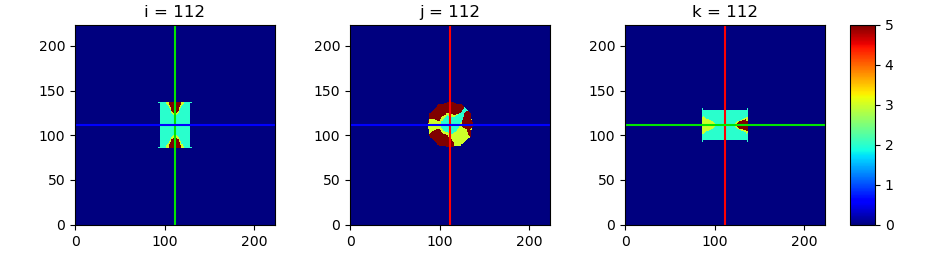

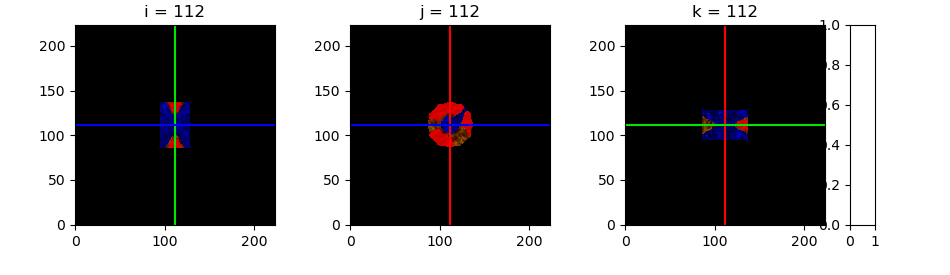

In [8]:
import project.visual.matplotlib as mpl_viz

ex = np.random.choice(examples)
mask = project.core.fileio.load_nibabel(ex.paths['material_mask']).get_fdata()
image = project.core.fileio.load_nibabel(ex.paths['input_image']).get_fdata()
print(image[mask > 0].mean(), image[mask > 0].std())
mpl_viz.SliceViewer(mask, cmap='jet')
mpl_viz.SliceViewer(image)

In [11]:
rgb = (image.ndim == 4 and image.shape[-1] == 3)
rgb

True

In [12]:
train_config = config['training'].copy()
project.core.utils.pprint(train_config, 2, 100)

dict(len=9)
├── 'task':            dict(len=3)
|   ├── 'inputs':  list(len=1)
|   ├── 'targets': list(len=1)
|   └── 'losses':  dict(len=1)
├── 'split':           dict(len=4)
|   ├── 'key':        'category'
|   ├── 'test_ratio': 0.2
|   ├── 'val_ratio':  0.1
|   └── 'seed':       0
├── 'transform':       dict(len=5)
|   ├── 'normalize':  True
|   ├── 'image_mean': 1.0
|   ├── 'image_std':  1.0
|   ├── 'apply_mask': True
|   └── 'do_augment': True
├── 'loader':          dict(len=6)
|   ├── 'batch_size':         1
|   ├── 'shuffle':            True
|   ├── 'num_workers':        2
|   ├── 'persistent_workers': True
|   ├── 'prefetch_factor':    2
|   └── 'pin_memory':         True
├── 'model':           dict(len=2)
|   ├── 'backbone': dict(len=11)
|   └── 'heads':    dict(len=1)
├── 'physics_adapter': dict(len=5)
|   ├── 'nu_value':      0.4
|   ├── 'rho_bias':      1000
|   ├── 'rho_known':     True
|   ├── 'scalar_degree': 1
|   └── 'vector_degree': 1
├── 'pde_solver':      dict(len=2)

In [13]:
import project.training
split_kws = train_config['split']
train_ex, test_ex, val_ex = project.training.split_on_metadata(examples, **split_kws)

len(train_ex), len(test_ex), len(val_ex)

Splitting examples
Test categories: {'ToyFigure', 'Copier', 'FoodItem', 'Computer', 'MediaStorage', 'Recliner', 'Microwave', 'Bed', 'CellPhone', 'DiscCase', 'DoubleBed', 'Calculator', 'Bathtub', 'TableLamp', 'CeilingLamp', 'DrinkBottle', 'Book', 'RubiksCube', 'Ball', 'CurioCabinet', 'Refrigerator', 'VideoGameController', 'TableClock'}
Test subjects:   {'wss.1d2a6082238f011c22d3f170937c6a0b', 'wss.20dec770602a8ac2331999dc8823fe0d', 'wss.2e36b4ec329c0cfe27152572287f9903', 'wss.2394aad19bdb0ca8e751791317b66d8c', 'wss.13b48456dad49f8762edbb9e1af21a03', 'wss.28ab2b0d2d8c918b77e1c4f3e3547f0c', 'wss.2b78edd5bc31b19ae0681a1280473149', 'wss.24505c53438f8273399f45f7c8fcdfa9', 'wss.28cae57a8d9f858b92eb9b3d545b01bd', 'wss.2acb67458c17af08c4b494041bc63422', 'wss.25370f9a01166beaa13edbe825cc0113', 'wss.1fd8d3cdf525532b5b5a685c28abd3e', 'wss.29830fb806fe23b29ccf01d06bf2094d', 'wss.266aba6a1b941c3a2bf3161ae4fda942', 'wss.29f66488d7507b0c5a93c9a5a7a08569', 'wss.263aa26d579b6def14c06184923f6962', 'wss.2

(68, 20, 10)

In [14]:
transform_kws = train_config['transform'].copy()
transform_kws['image_mean'] = 0.0
transform_kws['image_std']  = 1.0
transform_kws['do_augment'] = True
transform_kws

{'normalize': True,
 'image_mean': 0.0,
 'image_std': 1.0,
 'apply_mask': True,
 'do_augment': True}

In [15]:
%autoreload
import project.datasets.torch

use_cache = len(examples) < 100
train_set = project.datasets.torch.TorchDataset(train_ex, use_cache=use_cache, rgb=rgb, **transform_kws)
test_set = project.datasets.torch.TorchDataset(test_ex, use_cache=use_cache,  rgb=rgb, **transform_kws)
val_set = project.datasets.torch.TorchDataset(val_ex, use_cache=use_cache, rgb=rgb, **transform_kws)

In [16]:
loader_kws = train_config['loader'].copy()
loader_kws = {'batch_size': 1, 'num_workers': 0}
loader_kws

{'batch_size': 1, 'num_workers': 0}

In [17]:
collate_fn = project.datasets.torch.collate_fn
train_loader = torch.utils.data.DataLoader(train_set, collate_fn=collate_fn, **loader_kws)

if test_set:
    test_loader = torch.utils.data.DataLoader(test_set, collate_fn=collate_fn, **loader_kws)
else:
    test_loader = None

if val_set:
    val_loader = torch.utils.data.DataLoader(val_set, collate_fn=collate_fn, **loader_kws)
else:
    val_loader = None


In [18]:
import project.training

task_kws = train_config['task'].copy()

task_kws['inputs']  = ['image']
#task_kws['inputs']  = ['material']
#task_kws['inputs'] = ['mask']

#task_kws['targets'] = ['material']
#task_kws['losses']  = {'material': 'CE'}

task_kws['targets'] = ['logE']
task_kws['losses']  = {'logE': 'MSE'}

#task_kws['targets'] = ['material', 'logE']
#task_kws['losses']  = {'material': 'CE', 'logE': 'MSE'}
#task_kws['weights'] = {'material': 1.0, 'logE': 1.0}

task = project.training.TaskSpec(rgb=rgb, **task_kws)

Inputs:  ['image']
Targets: ['logE']
Losses:  {'logE': 'MSE'}


In [19]:
import copy
model_kws = copy.deepcopy(train_config['model'])

project.core.utils.pprint(model_kws, 3, 20)

dict(len=2)
├── 'backbone': dict(len=11)
|   ├── '_class':        'UNet3Dv2'
|   ├── 'out_channels':  16
|   ├── 'conv_channels': 16
|   ├── 'n_conv_units':  2
|   ├── 'n_sub_levels':  2
|   ├── 'kernel_size':   3
|   ├── 'relu_leak':     0.1
|   ├── 'norm_type':     'group'
|   ├── 'num_groups':    4
|   ├── 'pooling_type':  'max'
|   └── 'upsample_mode': 'trilinear'
└── 'heads':    dict(len=1)
    └── 'elasticity': dict(len=4)
        ├── 'logE_mean': 3.4863
        ├── 'logE_std':  0.3271
        ├── 'logE_min':  0.0
        └── 'logE_max':  6.0


In [20]:
%autoreload
import project.models
model = project.models.build_model(task, model_kws)
model

MultiTaskModel(
  (backbone): UNet3Dv2(
    (enc): ConvBlock3D(
      (unit0): ConvUnit3D(
        (conv): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (unit1): ConvUnit3D(
        (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (down): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (sub): UNet3Dv2(
      (enc): ConvBlock3D(
        (unit0): ConvUnit3D(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
          (norm): GroupNorm(4, 32, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slo

In [21]:
project.models.count_params(model)

backbone.enc.unit0.conv.weight                     1296	(16, 3, 3, 3, 3)
backbone.enc.unit0.norm.weight                     16	(16,)
backbone.enc.unit0.norm.bias                       16	(16,)
backbone.enc.unit1.conv.weight                     6912	(16, 16, 3, 3, 3)
backbone.enc.unit1.norm.weight                     16	(16,)
backbone.enc.unit1.norm.bias                       16	(16,)
backbone.sub.enc.unit0.conv.weight                 13824	(32, 16, 3, 3, 3)
backbone.sub.enc.unit0.norm.weight                 32	(32,)
backbone.sub.enc.unit0.norm.bias                   32	(32,)
backbone.sub.enc.unit1.conv.weight                 27648	(32, 32, 3, 3, 3)
backbone.sub.enc.unit1.norm.weight                 32	(32,)
backbone.sub.enc.unit1.norm.bias                   32	(32,)
backbone.sub.sub.enc.unit0.conv.weight             55296	(64, 32, 3, 3, 3)
backbone.sub.sub.enc.unit0.norm.weight             64	(64,)
backbone.sub.sub.enc.unit0.norm.bias               64	(64,)
backbone.sub.sub.enc.unit1.c

472129

In [22]:
import project.physics

pde_solver_kws = train_config['pde_solver'].copy()
pde_solver_cls = pde_solver_kws.pop('_class')

physics_adapter = project.physics.PhysicsAdapter(
    pde_solver_cls=pde_solver_cls,
    pde_solver_kws=pde_solver_kws,
    **train_config['physics_adapter']
)
physics_adapter

In [23]:
import torch.optim
optimizer_kws = train_config['optimizer'].copy()
optimizer_kws['lr'] = 1e-3
optimizer_cls = getattr(torch.optim, optimizer_kws.pop('_class'))
optimizer = optimizer_cls(model.parameters(), **optimizer_kws)

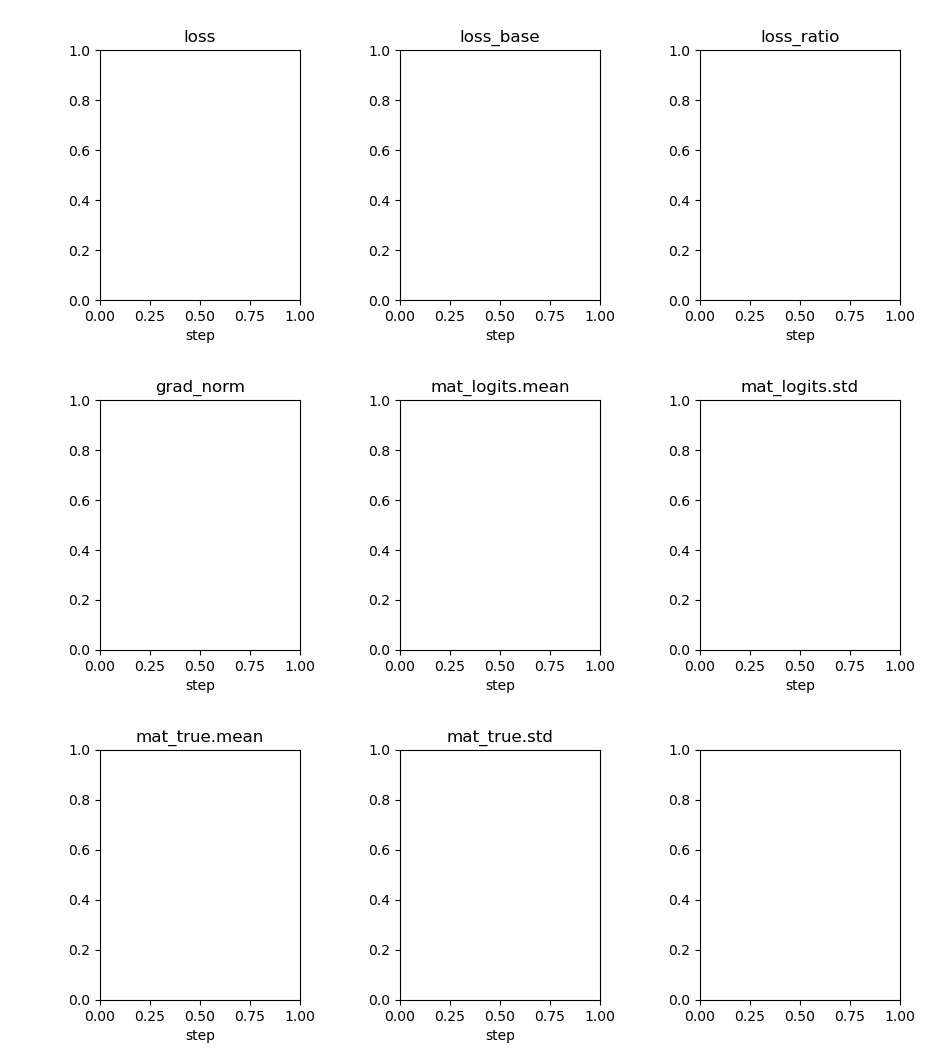

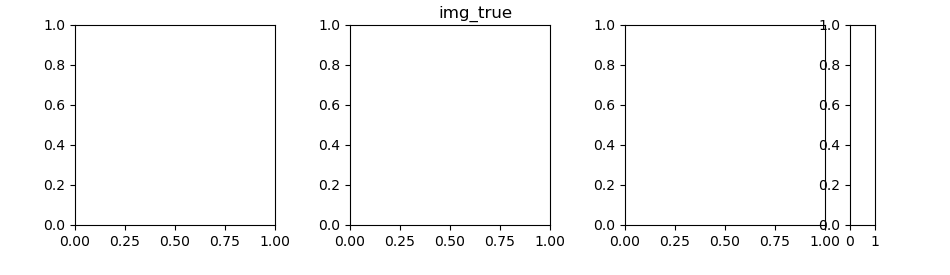

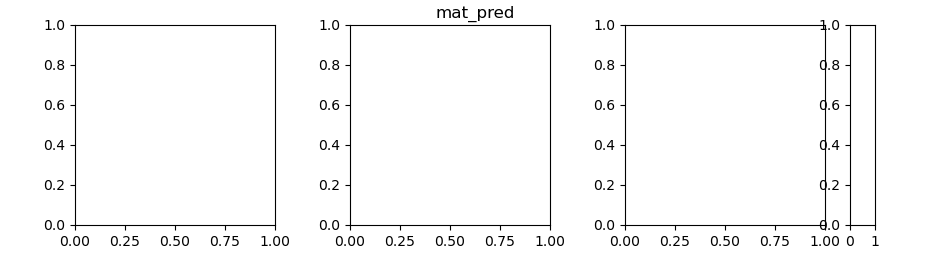

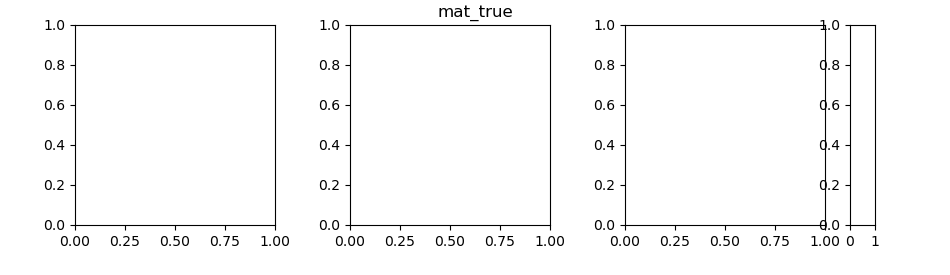

In [71]:
%autoreload
import project.training
import project.evaluation

trainer_kws = train_config['trainer'].copy()

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

callbacks = [
    project.evaluation.LoggerCallback(task.metric_keys),
    project.evaluation.PlotterCallback(task.metric_keys),
    project.evaluation.ViewerCallback(task.viewer_keys),
    project.evaluation.EvaluatorCallback(n_labels=task.material_labels),
    project.evaluation.TimerCallback(),
]

trainer = project.training.Trainer(
    task=task,
    model=model,
    optimizer=optimizer,
    physics_adapter=physics_adapter,
    train_loader=train_loader,
    test_loader=test_loader,
    val_loader=val_loader,
    callbacks=callbacks
)

In [72]:
%autoreload
#trainer.load_state(epoch=20)
trainer.train(num_epochs=20, val_every=1)

Start training
Start epoch 0
Saving checkpoints/checkpoint00000.pt
Start epoch 0 val phase
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1dd407598b5850959b1500745a428d00/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1dd407598b5850959b1500745a428d00/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1dd407598b5850959b1500745a428d00/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1dd407598b5850959b1500745a428d00/fields/mask_regions_uniform-seed_elastic.nii.gz
[Epoch 0 | Val batch 0] start
load_data: {'t_delta': 1.5334, 'curr_alloc': 0.0018, 'curr_rsvd': 7.3438, 'peak_alloc': 0.0018, 'peak_rsvd': 7.3438}
forward:   {'t_delta': 0.3455, 'curr_alloc': 0.0018, 'curr_rsvd': 7.3438, 'peak_alloc': 6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92616343..0.9248174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9304789..0.9493211].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92995816..0.93551046].


viewer: {'t_delta': 1.1409, 'curr_alloc': 0.0018, 'curr_rsvd': 7.3438, 'peak_alloc': 0.0018, 'peak_rsvd': 7.3438}
evaluator: {'t_delta': 0.2472, 'curr_alloc': 0.0018, 'curr_rsvd': 7.3438, 'peak_alloc': 0.0018, 'peak_rsvd': 7.3438}
timer: {'t_delta': 0.0026, 'curr_alloc': 0.0018, 'curr_rsvd': 7.3438, 'peak_alloc': 0.0018, 'peak_rsvd': 7.3438}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/208977431e9f1ebcd85b29704f5fc7f2/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/208977431e9f1ebcd85b29704f5fc7f2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/208977431e9f1ebcd85b29704f5fc7f2/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/208977431e9f1ebcd85b29704f5fc7f2/fields/mask_regions_uniform-see

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:196: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


plotter: {'t_delta': 2.5624, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3047, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3047}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7581804..0.93967205].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.73173076..0.9212685].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75713044..0.94290006].


viewer: {'t_delta': 1.15, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3047, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3047}
evaluator: {'t_delta': 0.1819, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3047, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3047}
timer: {'t_delta': 0.0014, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3047, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3047}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_uniform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91849643..0.92427415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9052664..0.92559016].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9102428..0.9254937].


viewer: {'t_delta': 1.0973, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3047, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3047}
evaluator: {'t_delta': 0.1558, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3047, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3047}
timer: {'t_delta': 0.0008, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3047, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3047}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d477fde8f2065a6654a12445bc75fbb/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d477fde8f2065a6654a12445bc75fbb/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d477fde8f2065a6654a12445bc75fbb/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d477fde8f2065a6654a12445bc75fbb/fields/mask_regions_unifo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8397467..0.7857923].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9189005..0.9378173].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.89121884..0.8122287].


viewer: {'t_delta': 1.1131, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3047, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3047}
evaluator: {'t_delta': 0.1512, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3047, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3047}
timer: {'t_delta': 0.0025, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3047, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3047}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_unifo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8564626..0.92282].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90158606..0.8977292].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8339684..0.84393924].


viewer: {'t_delta': 1.1091, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.2485, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0013, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_unifo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78921825..0.9453042].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78553957..0.936493].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.80401134..0.91362196].


viewer: {'t_delta': 1.11, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.2985, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0016, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/26205c6a0a25d5f884099151cc96de84/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/26205c6a0a25d5f884099151cc96de84/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/26205c6a0a25d5f884099151cc96de84/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/26205c6a0a25d5f884099151cc96de84/fields/mask_regions_uniform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.934825..0.9434921].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94926524..0.94419944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93456477..0.94724876].


viewer: {'t_delta': 1.1731, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.158, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0008, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2a21b9d109d2fc958962005ce0e986db/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2a21b9d109d2fc958962005ce0e986db/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2a21b9d109d2fc958962005ce0e986db/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2a21b9d109d2fc958962005ce0e986db/fields/mask_regions_unifor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9231564..0.92422515].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9332281..0.9247102].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94364643..0.929702].


viewer: {'t_delta': 1.0995, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.3903, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0016, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2ec608cc4d3287bb92e0b07fda7527d0/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2ec608cc4d3287bb92e0b07fda7527d0/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2ec608cc4d3287bb92e0b07fda7527d0/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2ec608cc4d3287bb92e0b07fda7527d0/fields/mask_regions_unifo

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:196: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


plotter: {'t_delta': 0.634, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93065566..0.94791317].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9334582..0.9493882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9329517..0.95520353].


viewer: {'t_delta': 1.1095, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.2258, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0014, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/208977431e9f1ebcd85b29704f5fc7f2/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/208977431e9f1ebcd85b29704f5fc7f2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/208977431e9f1ebcd85b29704f5fc7f2/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/208977431e9f1ebcd85b29704f5fc7f2/fields/mask_regions_unifo

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:196: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


plotter: {'t_delta': 0.6509, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75286525..0.9471954].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79211813..0.9450626].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8224291..0.9351655].


viewer: {'t_delta': 1.1242, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.162, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0014, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_unifor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9173946..0.92559016].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91926014..0.917483].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9102428..0.9254937].


viewer: {'t_delta': 1.118, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.1504, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0008, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d477fde8f2065a6654a12445bc75fbb/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d477fde8f2065a6654a12445bc75fbb/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d477fde8f2065a6654a12445bc75fbb/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d477fde8f2065a6654a12445bc75fbb/fields/mask_regions_unifor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81400645..0.7937148].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92388797..0.9289272].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76867837..0.7751262].


viewer: {'t_delta': 1.1256, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.1583, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0017, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_unifo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8564626..0.92282].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8755896..0.9454542].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8364436..0.90090114].


viewer: {'t_delta': 1.1962, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.2333, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0014, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_unifo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78967625..0.93134123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8407864..0.940552].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76807344..0.93729746].


viewer: {'t_delta': 1.1216, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.3032, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0015, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/26205c6a0a25d5f884099151cc96de84/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/26205c6a0a25d5f884099151cc96de84/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/26205c6a0a25d5f884099151cc96de84/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/26205c6a0a25d5f884099151cc96de84/fields/mask_regions_unifo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9490423..0.940674].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9455948..0.9473434].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92851216..0.92746556].


viewer: {'t_delta': 1.1224, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.1581, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0014, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2a21b9d109d2fc958962005ce0e986db/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2a21b9d109d2fc958962005ce0e986db/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2a21b9d109d2fc958962005ce0e986db/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2a21b9d109d2fc958962005ce0e986db/fields/mask_regions_unifo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92099327..0.93716973].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9328516..0.9348405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.929721..0.9292831].


viewer: {'t_delta': 1.1133, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.3768, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0014, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2ec608cc4d3287bb92e0b07fda7527d0/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2ec608cc4d3287bb92e0b07fda7527d0/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2ec608cc4d3287bb92e0b07fda7527d0/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2ec608cc4d3287bb92e0b07fda7527d0/fields/mask_regions_unifo

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:196: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


plotter: {'t_delta': 0.64, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9331359..0.9365259].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92742753..0.94280106].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9188164..0.93893397].


viewer: {'t_delta': 1.1129, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
evaluator: {'t_delta': 0.247, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
timer: {'t_delta': 0.0015, 'curr_alloc': 0.0053, 'curr_rsvd': 18.3066, 'peak_alloc': 0.0053, 'peak_rsvd': 18.3066}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/208977431e9f1ebcd85b29704f5fc7f2/images/mask_regions_uniform-seed_min_max-0.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/208977431e9f1ebcd85b29704f5fc7f2/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/208977431e9f1ebcd85b29704f5fc7f2/meshes/mask_regions_uniform-seed_min_max-0_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/208977431e9f1ebcd85b29704f5fc7f2/fields/mask_regions_unifor


KeyboardInterrupt

